# XỬ LÝ DỮ LIỆU OLD DATA
Mục tiêu của notebook này là xử lý dữ liệu có sẵn (old data) đã thu thập từ Google Data Search.

Dữ liệu thu thập được bao gồm:   
Timestamp: Thời gian giao dịch.  
Open: Giá mở cửa của cặp tiền điện tử.  
High: Giá cao nhất trong ngày.  
Low: Giá thấp nhất trong ngày.  
Close: Giá đóng cửa của cặp tiền điện tử.  
Volume: Khối lượng giao dịch trong ngày.  
Pair: Tên cặp tiền điện tử đã thực hiện giao dịch.  
Exchange: Tên sàn giao dịch đã thực hiện giao dịch.

Chúng ta sẽ làm sạch, xử lý giá trị thiếu, tạo đặc trưng, và xử lý cân mất cân bằng dữ liệu.


## CẤU TRÚC NOTEBOOK
1. **Đọc dữ liệu**:  
   Tải dữ liệu từ nguồn hoặc file đã lưu.
2. **Phân tích dữ liệu**:  
   Vẽ các biểu đồ phân tích.
3. **Làm sạch dữ liệu**:  
   Xử lý giá trị thiếu, trùng lặp và chuyển đổi định dạng.
4. **Tạo đặc trưng (Feature Engineering)**:  
   Tạo thêm các chỉ số kỹ thuật.
5. **Cân bằng dữ liệu**:  
   Dùng SMOTE để cân bằng tập dữ liệu.
6. **Lưu dữ liệu đã xử lý**:  
   Lưu kết quả để sử dụng cho các bước tiếp theo.


#### Import các thư viện

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#### Đường dẫn thư mục

In [2]:
# Đường dẫn thư mục
data_dir = "../data/old_data/"
processed_dir = os.path.join(data_dir, "processed")
plot_dir = "../plots/data_analysis"

# Tạo thư mục lưu trữ dữ liệu nếu chưa có
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# Danh sách các sàn giao dịch
exchanges = ["binance", "bittrex", "kraken", "kucoin", "lbank"]

### Đọc dữ liệu
Chúng ta sử dụng thư viện pandas để đọc dữ liệu từ thư mục `data/raw/old_data`.

Sau đó hợp nhất dữ liệu.


In [3]:
# Hợp nhất dữ liệu từ các file CSV
all_data = []

for exchange in exchanges:
    exchange_dir = os.path.join(data_dir, "raw", exchange)
    files = [f for f in os.listdir(exchange_dir) if f.endswith(".csv")]

    for file in files:
        file_path = os.path.join(exchange_dir, file)
        df = pd.read_csv(file_path)
        
        # Lấy thông tin cặp giao dịch từ tên file
        pair = file.split("_")[1]
        
        # Thêm cột thông tin
        df["Pair"] = pair
        df["Exchange"] = exchange
        all_data.append(df)

# Hợp nhất toàn bộ dữ liệu
data = pd.concat(all_data, ignore_index=True)
print("Dữ liệu ban đầu:")
print(data.head())


Dữ liệu ban đầu:
   Unnamed: 0            Timestamp      Open      High       Low     Close  \
0           0  2018-04-20 00:00:00  0.032400  0.032536  0.032249  0.032295   
1           1  2018-04-20 01:00:00  0.032377  0.032399  0.031879  0.032141   
2           2  2018-04-20 02:00:00  0.032140  0.032733  0.031999  0.032576   
3           3  2018-04-20 03:00:00  0.032628  0.032701  0.032290  0.032290   
4           4  2018-04-20 04:00:00  0.032290  0.032374  0.031880  0.032105   

    Volume     Pair Exchange  
0  1387.89  ETC-ETH  binance  
1  2582.66  ETC-ETH  binance  
2  3393.88  ETC-ETH  binance  
3   959.78  ETC-ETH  binance  
4  2508.01  ETC-ETH  binance  


In [4]:
# Lưu dữ liệu đã xử lý
processed_file = os.path.join(processed_dir, "data_concated.csv")
data.to_csv(processed_file, index=False)
print(f"Dữ liệu đã lưu tại: {processed_file}")

Dữ liệu đã lưu tại: ../data/old_data/processed/data_concated.csv


### Phân Tích Dữ Liệu

#### Biểu đồ phân phối khối lượng giao dịch (Volume)

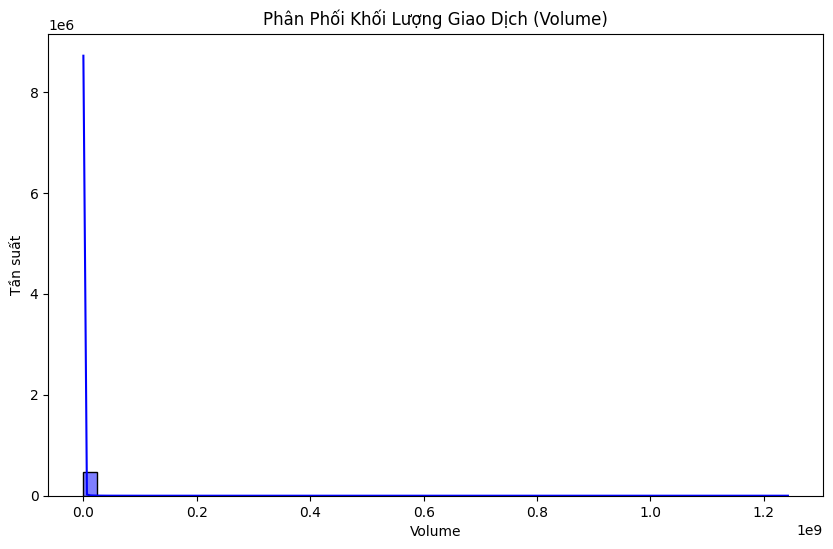

In [13]:
# Vẽ biểu đồ phân phối Volume
plt.figure(figsize=(10, 6))
sns.histplot(data["Volume"], bins=50, kde=True, color='blue')
plt.title("Phân Phối Khối Lượng Giao Dịch (Volume)")
plt.xlabel("Volume")
plt.ylabel("Tần suất")
plt.savefig(os.path.join(plot_dir, "volume_distribution.png"))
plt.show()

#### Biểu đồ biến động giá (Price Volatility)

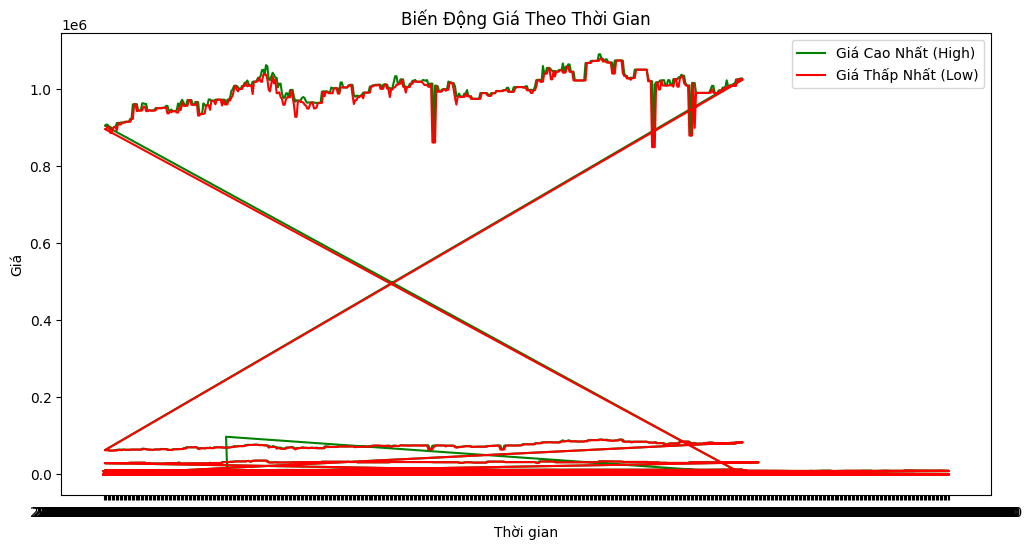

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(data["Timestamp"], data["High"], label='Giá Cao Nhất (High)', color='green')
plt.plot(data["Timestamp"], data["Low"], label='Giá Thấp Nhất (Low)', color='red')
plt.title("Biến Động Giá Theo Thời Gian")
plt.xlabel("Thời gian")
plt.ylabel("Giá")
plt.legend()
plt.savefig(os.path.join(plot_dir, "price_volatility.png"))
plt.show()


#### Ma trận tương quan giữa các đặc trưng

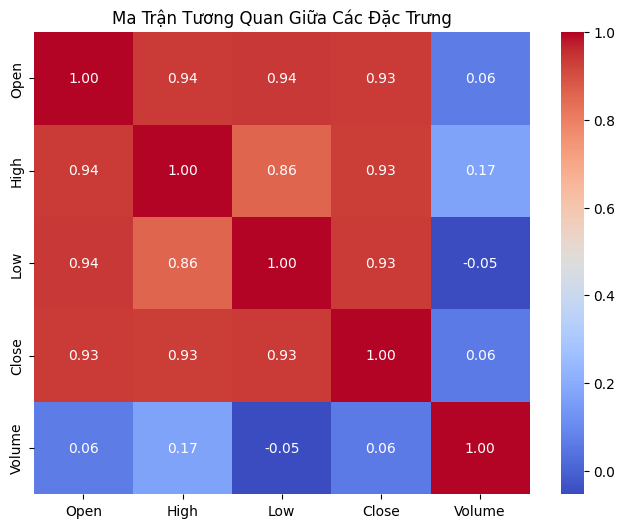

In [15]:
plt.figure(figsize=(8, 6))
correlation = df[["Open", "High", "Low", "Close", "Volume"]].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Ma Trận Tương Quan Giữa Các Đặc Trưng")
plt.savefig(os.path.join(plot_dir, "correlation_matrix.png"))
plt.show()


### Làm sạch dữ liệu
Các bước bao gồm:  
  Xóa dữ liệu trùng lặp.  
  Loại bỏ các giao dịch không hợp lệ (giá trị âm, null).  
  Chuyển đổi định dạng thời gian `Timestamp` sang datetime.  


In [5]:
# Chuyển Timestamp sang datetime
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

# Loại bỏ giá trị trùng lặp
data.drop_duplicates(subset=["Timestamp", "Pair", "Exchange"], inplace=True)

# Sắp xếp dữ liệu
data.sort_values(by="Timestamp", inplace=True)
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 468955 entries, 0 to 449760
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Unnamed: 0  468955 non-null  int64         
 1   Timestamp   468955 non-null  datetime64[ns]
 2   Open        454238 non-null  float64       
 3   High        454238 non-null  float64       
 4   Low         454236 non-null  float64       
 5   Close       454238 non-null  float64       
 6   Volume      468955 non-null  float64       
 7   Pair        468955 non-null  object        
 8   Exchange    468955 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 35.8+ MB
None


#### Điền giá trị thiếu bằng phương pháp Linear Interpolation
Phương pháp Linear Interpolation là một kỹ thuật để ước lượng và thay thế các giá trị bị thiếu (NaN) trong dữ liệu dựa trên các giá trị liền kề. 

In [6]:
# Kiểm tra giá trị thiếu
missing_values = data.isnull().sum()
print("Giá trị thiếu:\n", missing_values)

# Điền giá trị thiếu bằng phương pháp Linear Interpolation
data.interpolate(method="linear", inplace=True)

# Xác nhận lại không còn giá trị thiếu
print("Giá trị thiếu after sau khi điền:\n", data.isnull().sum())


Giá trị thiếu:
 Unnamed: 0        0
Timestamp         0
Open          14717
High          14717
Low           14719
Close         14717
Volume            0
Pair              0
Exchange          0
dtype: int64
Giá trị thiếu after sau khi điền:
 Unnamed: 0    0
Timestamp     0
Open          0
High          0
Low           0
Close         0
Volume        0
Pair          0
Exchange      0
dtype: int64


/var/folders/rz/mr63129s7vs6092h_t0czm140000gn/T/ipykernel_6514/135319873.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method="linear", inplace=True)


### Tạo đặc trưng (Feature Engineering)
Chúng ta thêm các đặc trưng mới để hỗ trợ mô hình học máy:
- **Tăng đột biến khối lượng (Volume Spike)**.
- **Tỷ lệ thay đổi giá (Price Change %)**.
- **Biến động giá (Volatility)**.


In [ ]:
# Tính toán các đặc trưng mới
data["Price_Change_Pct"] = (data["Close"] - data["Open"]) / data["Open"] * 100
data["Volume_Spike"] = data["Volume"] / data["Volume"].rolling(window=10).mean()
data["Volatility"] = data["High"] - data["Low"]

# Điền NaN trong cột mới (do rolling tạo ra)
data.fillna(0, inplace=True)


print("Dữ liệu với đặc trưng mới:")
print(data[["Price_Change_Pct", "Volume_Spike", "Volatility"]].head())


### Chuẩn hoá dữ liệu
 

Chuẩn hoá các cột cần thiết bằng MinMaxScaler.

In [ ]:
# Chuẩn hóa các cột
scaler = MinMaxScaler()

columns_to_scale = ["Open", "High", "Low", "Close", "Volume"]
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

print("Dữ liệu sau chuẩn hóa:")
print(data.head())

In [ ]:
def statistical_rules(df):
    # Tính các ngưỡng thống kê
    price_change_threshold = df['Price_Change_Pct'].quantile(0.95)
    volume_spike_threshold = df['Volume_Spike'].quantile(0.95)
    volatility_threshold = df['Volatility'].quantile(0.95)

    # Áp dụng quy tắc vectorized
    price_anomaly = (abs(df['Price_Change_Pct']) > price_change_threshold)
    volume_anomaly = (df['Volume_Spike'] > volume_spike_threshold)
    volatility_anomaly = (df['Volatility'] > volatility_threshold)

    # Kết hợp các điều kiện
    return ((price_anomaly & volume_anomaly) |
            (price_anomaly & volatility_anomaly) |
            (volume_anomaly & volatility_anomaly)).astype(int)


In [ ]:
# Bước 2: Phát hiện bất thường bằng Isolation Forest với xử lý batch
def isolation_forest_batch(df, batch_size=10000):
    features = ['Open', 'High', 'Low', 'Close', 'Volume',
               'Price_Change_Pct', 'Volume_Spike', 'Volatility']

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features])

    labels = np.zeros(len(df))

    # Xử lý từng batch
    for i in range(0, len(df), batch_size):
        batch = scaled_features[i:i+batch_size]
        iso_forest = IsolationForest(contamination=0.01, random_state=42)
        batch_labels = (iso_forest.fit_predict(batch) == -1).astype(int)
        labels[i:i+batch_size] = batch_labels

    return labels


In [ ]:

# Bước 3: Phân cụm để phát hiện mẫu bất thường
def cluster_anomalies(df, n_clusters=50):
    features = ['Open', 'High', 'Low', 'Close', 'Volume',
               'Price_Change_Pct', 'Volume_Spike', 'Volatility']

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features])

    # Sử dụng MiniBatchKMeans cho hiệu năng tốt hơn
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Đánh dấu các cụm nhỏ là bất thường
    cluster_sizes = np.bincount(cluster_labels)
    small_clusters = cluster_sizes < np.percentile(cluster_sizes, 10)
    return np.isin(cluster_labels, np.where(small_clusters)[0]).astype(int)


In [ ]:
labels_stats = statistical_rules(data)
labels_iforest = isolation_forest_batch(data)
labels_cluster = cluster_anomalies(data)

In [ ]:
# Kết hợp kết quả từ 3 phương pháp
final_labels = ((labels_stats + labels_iforest + labels_cluster) >= 2).astype(int)

### Lưu dữ liệu
Dữ liệu sau khi xử lý được lưu vào file `data/processed/data_processed.csv`.


In [ ]:
# Lưu dữ liệu đã xử lý
processed_file = os.path.join(processed_dir, "data_processed.csv")
data.to_csv(processed_file, index=False)
print(f"Dữ liệu đã lưu tại: {processed_file}")
